In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import json
import re
import requests

import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
SEED = 42

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Exploratory Data Analysis and Metric

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [ ]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [ ]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


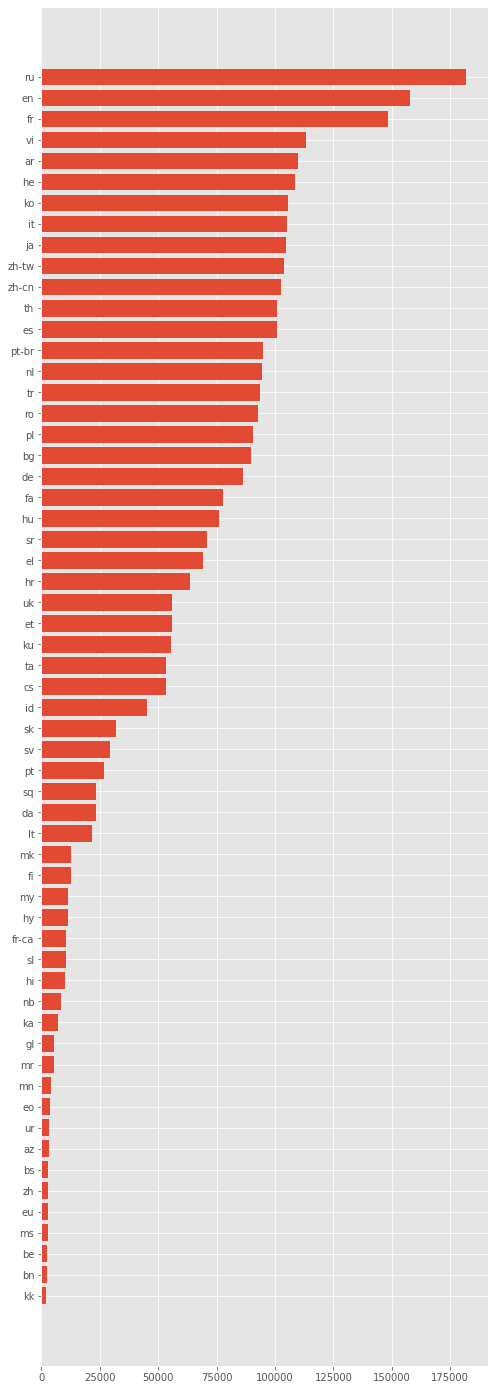

In [ ]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [ ]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [ ]:
x = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

# Model 1

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='modified_huber', class_weight='balanced'))
])

In [ ]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                   

In [ ]:
predictions = pipe.predict(x_train)

In [ ]:
balanced_accuracy_score(y_train, predictions)

0.907782857448568

In [ ]:
test_predictions = pipe.predict(x_test)

In [ ]:
balanced_accuracy_score(y_test, test_predictions)

0.8556371542723332

# Weight models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, ngram_range=(1, 1), min_df=3, max_df=0.8)),
    ('model', SGDClassifier(random_state=SEED, loss='modified_huber', class_weight= 'balanced'))
])

In [ ]:
pipeline.fit(x_train, y_train)

In [ ]:
predictions = pipeline.predict(x_train)

In [ ]:
balanced_accuracy_score(y_train, predictions)

0.8893643773645261

In [ ]:
test_predictions = pipeline.predict(x_test)

In [ ]:
balanced_accuracy_score(y_test, test_predictions)

0.8645779121625746

# Submit 1

In [ ]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

In [ ]:
(
    test_df[['index',  'language']]
    .to_csv('sample_submission.csv', index=False)
)

# Submit 2

In [ ]:
submit_predictions = pipeline.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = label_encoder.classes_[submit_predictions]
test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,zh-tw


In [ ]:
(
    test_df[['index',  'language']]
    .to_csv('subm_modified_huber.csv', index=False)
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
y_test != test_predictions

array([ True, False, False, ..., False, False, False])

In [ ]:
y_test.shape, test_predictions.shape

((631927,), (631927,))

In [ ]:
new_df = test_df[:631927]
new_df['y_test'] = y_test
new_df['test_predictions'] = test_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
new_df

,index,sentence,y_test,test_predictions
0,0,תודה לכם .,5,22
1,1,"Precisamos de compaixão para começar , e auto-...",57,57
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,10,10
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,10,10
4,4,これをロボットに組み込みました,41,42
...,...,...,...,...
631922,631922,Number two : places like where I work at Harva...,24,27
631923,631923,そのうちの67 ％ が 最も寂しい時期は 子供が0 〜 5歳の時だと答えています 特に0 〜...,9,9
631924,631924,Wat is de bepalende factor die me de ervarings...,44,44
631925,631925,بعد ستة بلايين سنة ، ستبدو الشمس هكذا,17,17


In [ ]:
train_df.dtypes.value_counts()

object    2
dtype: int64

In [ ]:
train_df.isnull().sum()

sentence    0
language    0
dtype: int64

In [ ]:
pipe.get_params()

{'memory': None,
 'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
               n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
               random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 'model__alpha': 0.0001,
 'model__average': False,
 'model__class_weight': None,
 'model__early_stopping': False,
 'model__epsilon': 0.1,
 'model__eta0': 0.0,
 'model__fit_intercept': True,
 'model__l1_ratio': 0.15,
 'model__learning_rate': 'optimal',
 'model__loss': 'log',
 'model__max_iter': 1000,
 'model__n_iter_no_change': 5,
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__power_t': 0.5,
 'model__random_state': 42,
 'model__shuffle': True,
 'model__tol': 0.001,
 'model__validation_fraction': 0.1,
 'model__verbose': 0,
 'model__

In [ ]:
stop_words = nltk.corpus.stopwords.words('russian')

In [ ]:
 count_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern="[а-яё]+",
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

# Токенизация

In [ ]:
import re
#import razdel
import nltk

In [ ]:
a = list(train_df.sentence)

In [ ]:
b =' '.join(a) 

In [ ]:
nltk.tokenize.casual_tokenize(b)

['Pensez',
 'à',
 'la',
 'communication',
 ',',
 'le',
 'discours',
 ',',
 'les',
 'gestes',
 ',',
 'écrire',
 ',',
 'le',
 'langage',
 'des',
 'signes',
 ',',
 'ils',
 'sont',
 'tous',
 'faits',
 'par',
 'l',
 'intermédiaire',
 'de',
 'contractions',
 'musculaires',
 '.',
 'Můžete',
 'si',
 'ji',
 'pronajmout',
 ',',
 'vzít',
 'na',
 'splátky',
 ',',
 'koupit',
 'technologii',
 ',',
 'která',
 'téměř',
 'stejná',
 'nebo',
 'stejná',
 'jako',
 'ta',
 ',',
 'kterou',
 'používají',
 '„',
 'ti',
 'oprávnění',
 '"',
 '"',
 '.',
 'Žádná',
 'společnost',
 'neprospívá',
 'nejlépe',
 ',',
 'má-li',
 'vše',
 'pod',
 'kontrolou',
 'jen',
 'elita',
 '.',
 'Každý',
 'starosta',
 'pochopil',
 ',',
 'že',
 'když',
 'mají',
 'tyto',
 'formy',
 ',',
 'mají',
 'i',
 'kulturu',
 'a',
 'turismus',
 '.',
 'Det',
 'är',
 'ytterligare',
 'bevis',
 ',',
 'men',
 'ändå',
 '—',
 'Jag',
 'kritiserades',
 'av',
 'en',
 'forskare',
 'som',
 'sa',
 ',',
 '"',
 '"',
 'Du',
 'kan',
 'aldrig',
 'publicera',
 'en',
 '

In [ ]:
from collections import Counter 

In [ ]:
c = Counter(nltk.tokenize.casual_tokenize(b))

In [ ]:
с.hist(bins=200)

In [ ]:
nltk.corpus.stopwords.words('russian')